# **0.0 Import**

In [1]:
#conda --version

In [2]:
## Observação: estava dando erro depois que atualizei o conda version - o problema era a versão do pillow coloquei 9.3.0 e funcionou

#import PIL
#print(PIL.__version__)


In [3]:
!pip install scipy
!pip install inflection

In [4]:
#import PIL
import warnings
import inflection

import pandas              as pd
import numpy               as np

import seaborn             as sns
from matplotlib                     import pyplot             as plt

from tabulate                       import tabulate
from IPython.core.display           import HTML
from IPython.display                import Image

In [5]:
import pandas as pd
print(pd.__version__)


2.2.2


In [6]:
np.version.version

'2.0.2'

## **0.1 Helper Functions**

In [7]:
#Configuração gerais
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()
jupyter_settings()


# Transforma colunas em snakecase
def convert_to_snake_case(df):
    cols_old = df.columns.tolist()
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df


#Estatística descritiva - medidas central.
def descriptive_statistics(df1_num):

    # Central Tendency - mean, meadina
    ct1= pd.DataFrame(df1_num.apply(np.mean)).T
    ct2= pd.DataFrame(df1_num.apply(np.median)).T

    # dispersion - std, min, max, range, skew, kurtosis
    ct3= pd.DataFrame(df1_num.apply(np.std)).T
    ct4= pd.DataFrame(df1_num.apply(min)).T
    ct5= pd.DataFrame(df1_num.apply(max)).T
    ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
    ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
    ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
    #ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T

    # concatenar
    df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8]).T
    df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    df_statistics.round(2)

    return df_statistics


#Gráfico de correlação
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap="Blue").set_title(col);

    return plot


#Correlação variáveis categóricas
def cramer_v(x, y):
    # cramer V function to calculate correlation btw categorical variables
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = chi2_contingency(cm)[0]

    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


warnings.filterwarnings ("ignore")


Populating the interactive namespace from numpy and matplotlib


## **0.2 Loading Data**

In [8]:
df_raw_A25 = pd.read_csv("airbnb_01_2025-06_2025.csv", low_memory = False)
df_raw_A24 = pd.read_csv("airbnb_01_2024-12_2024.csv", low_memory = False)
df_raw_A23 = pd.read_csv("airbnb_01_2023-12_2023.csv",low_memory = False)
df_raw_A22 = pd.read_csv("airbnb_07_2022-12_2022.csv",low_memory = False)

In [9]:
# Listar as colunas de cada DataFrame
colunas_A25 = set(df_raw_A25.columns)
colunas_A24 = set(df_raw_A24.columns)
colunas_A23 = set(df_raw_A23.columns)
colunas_A22 = set(df_raw_A22.columns)

# Identificar todas as colunas únicas (que existem em pelo menos um DataFrame)
todas_colunas = colunas_A25 | colunas_A24 | colunas_A23 | colunas_A22

# Identificar colunas comuns a todos os DataFrames
comuns = colunas_A25 & colunas_A24 & colunas_A23 & colunas_A22

# Identificar colunas diferentes (que não são comuns)
diferentes = todas_colunas - comuns

# Mostrar as colunas diferentes
print("Colunas diferentes entre os DataFrames:", diferentes)


Colunas diferentes entre os DataFrames: {'Taxa de serviço', 'Taxa de serviço do anfitrião'}


In [10]:
df_raw_A23.rename(columns={'Taxa de serviço do anfitrião': 'Taxa de serviço'}, inplace=True)
df_raw_A22.rename(columns={'Taxa de serviço do anfitrião': 'Taxa de serviço'}, inplace=True)

In [11]:
#verificando se alterou o nome da coluna
df_raw_A22.columns

Index(['Data', 'Disponível por data', 'Tipo', 'Código de Confirmação',
       'Data da reserva', 'Data de início', 'Data de término', 'Noites',
       'Hóspede', 'Anúncio', 'Detalhes', 'Código de referência', 'Moeda',
       'Valor', 'Pago', 'Taxa de serviço', 'Taxa de pagamento rápido',
       'Taxa de limpeza', 'Ganhos brutos', 'Impostos de ocupação',
       'Ganhos do ano'],
      dtype='object')

In [12]:
df_raw = pd.concat([df_raw_A22, df_raw_A23, df_raw_A24, df_raw_A25], ignore_index=True)

# **1.0 Data Description**

In [13]:
df1 = df_raw.copy()

## **1.1 Rename Columns**

In [14]:
df1.columns

Index(['Data', 'Disponível por data', 'Tipo', 'Código de Confirmação',
       'Data da reserva', 'Data de início', 'Data de término', 'Noites',
       'Hóspede', 'Anúncio', 'Detalhes', 'Código de referência', 'Moeda',
       'Valor', 'Pago', 'Taxa de serviço', 'Taxa de pagamento rápido',
       'Taxa de limpeza', 'Ganhos brutos', 'Impostos de ocupação',
       'Ganhos do ano'],
      dtype='object')

In [15]:
df1 = convert_to_snake_case(df1)

## **1.2 Data Dimensions**

In [16]:
print("Numero de linhas:{}".format(df1.shape[0]))
print("Numero de colunas:{}".format(df1.shape[1]))

Numero de linhas:240
Numero de colunas:21


## **1.3 Data Types**

In [17]:
df1.dtypes

,0
data,object
disponível por data,object
tipo,object
código de confirmação,object
data da reserva,object
data de início,object
data de término,object
noites,float64
hóspede,object
anúncio,object


## **1.4 Check NA**

In [18]:
round((df1.isna().sum()/len(df1))*100, 2)

,0
data,0.00
disponível por data,50.42
tipo,0.00
código de confirmação,49.58
data da reserva,52.92
data de início,50.42
data de término,50.83
noites,50.83
hóspede,50.83
anúncio,50.83


## **1.5 Fillout NA**

## **1.6 Change Types**

In [19]:
df1.head()

,data,disponível por data,tipo,código de confirmação,data da reserva,data de início,data de término,noites,hóspede,anúncio,detalhes,código de referência,moeda,valor,pago,taxa de serviço,taxa de pagamento rápido,taxa de limpeza,ganhos brutos,impostos de ocupação,ganhos do ano
0,12/12/2022,12/14/2022,Payout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3nd...,BRL,NaN,3286.69,NaN,NaN,NaN,NaN,NaN,NaN
1,12/12/2022,NaN,Reserva,HMAH343HFP,10/03/2022,10/10/2022,01/07/2023,89.0,Katarine Costa,The Águas Claras experience,NaN,NaN,BRL,3286.69,NaN,101.74,NaN,31.46,3388.43,0.0,2022.0
2,11/11/2022,11/16/2022,Payout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3ne...,BRL,NaN,3521.45,NaN,NaN,NaN,NaN,NaN,NaN
3,11/11/2022,NaN,Reserva,HMAH343HFP,10/03/2022,10/10/2022,01/07/2023,89.0,Katarine Costa,The Águas Claras experience,NaN,NaN,BRL,3521.45,NaN,109.01,NaN,33.71,3630.46,0.0,2022.0
4,10/11/2022,10/14/2022,Payout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3ne...,BRL,NaN,3638.83,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#data
#df1['data'] = pd.to_datetime(df1['data'], errors='coerce')


In [21]:
# Converter as colunas para datetime, ignorando erros em valores NaN
for col in ['data','disponível por data', 'data da reserva', 'data de início', 'data de término', 'ganhos do ano']:
    df1[col] = pd.to_datetime(df1[col], errors='coerce')


In [22]:
# Converte tipos para integer e float
#df1['noites'] = pd.to_numeric(df1['noites'], errors='coerce').astype('Int64')


In [23]:
df1.dtypes

,0
data,datetime64[ns]
disponível por data,datetime64[ns]
tipo,object
código de confirmação,object
data da reserva,datetime64[ns]
data de início,datetime64[ns]
data de término,datetime64[ns]
noites,float64
hóspede,object
anúncio,object


In [24]:
#def convert_date_format(df, columns):
#    for column in columns:
#        df[column] = pd.to_datetime(df[column])
#        df[column] = df[column].dt.strftime('%d/%m/%Y')

In [25]:
# Especificar as colunas que precisam ser convertidas
#date_columns = ['data', 'disponível por data', 'data da reserva', 'data de início', 'data de término']
#convert_date_format(df1, date_columns)

In [26]:
#de onde veio a função

##data
#df1_A22['data'] = pd.to_datetime(df1_A22['data'])
## Convertendo para o formato de data do Brasil (DD/MM/YYYY)
#df1_A22['data'] = df1_A22['data'].dt.strftime('%d/%m/%Y')


## **1.7 Descriptive Statistical**

In [27]:
df1_num=df1.select_dtypes(include=['int64', 'float64'])
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### **1.7.1 Numerical Attributes**

In [28]:
df1_num.describe()

,noites,valor,pago,taxa de serviço,taxa de pagamento rápido,taxa de limpeza,ganhos brutos,impostos de ocupação
count,118.000000,121.000000,119.000000,113.000000,0.0,113.000000,121.000000,113.0
mean,8.635593,1191.611818,1211.638908,39.278319,NaN,135.575221,1227.869752,0.0
std,14.820098,1005.459265,1000.801596,31.385706,NaN,51.062535,1036.511296,0.0
min,1.000000,-300.000000,58.750000,8.100000,NaN,0.000000,-300.000000,0.0
25%,3.000000,616.350000,625.560000,20.070000,NaN,150.000000,635.430000,0.0
50%,4.000000,883.820000,902.240000,28.800000,NaN,150.000000,911.180000,0.0
75%,7.000000,1402.290000,1423.175000,44.700000,NaN,150.000000,1445.700000,0.0
max,89.000000,5378.530000,5378.530000,166.500000,NaN,190.000000,5545.030000,0.0


In [29]:
maior_valor_pago = df1['pago'].max()
maior_valor_pago

5378.53

In [30]:
menor_valor_pago = df1['pago'].min()
menor_valor_pago

58.75

In [31]:
# Acha o índice
indice_menor_valor = df1['pago'].idxmin()

# loc na linha do DataFrame
linha_menor_valor = df1.loc[indice_menor_valor]

print(linha_menor_valor)

data                                                      2024-10-31 00:00:00
disponível por data                                       2024-11-05 00:00:00
tipo                                                                   Payout
código de confirmação                                                     NaN
data da reserva                                                           NaT
data de início                                                            NaT
data de término                                                           NaT
noites                                                                    NaN
hóspede                                                                   NaN
anúncio                                                                   NaN
detalhes                    Transferir para Raquel Rocha Silva Rego, •••••...
código de referência        Identificação de pagamento da Payoneer: 0MS3nc...
moeda                                                           

In [32]:
print(df1[df1['hóspede'] == 'Marcelo Mainardi'])


          data disponível por data                    tipo código de confirmação data da reserva data de início data de término  noites           hóspede                      anúncio                                           detalhes código de referência moeda    valor  pago  taxa de serviço  taxa de pagamento rápido  taxa de limpeza  ganhos brutos  impostos de ocupação                 ganhos do ano
130 2024-10-31                 NaT  Pagamento da Resolução            HMK3AXB4HK             NaT     2024-10-14      2024-10-21     7.0  Marcelo Mainardi  The Águas Claras experience                Pagamento para a resolução 35518330                  NaN   BRL     8.75   NaN              NaN                       NaN              NaN           8.75                   NaN 1970-01-01 00:00:00.000002024
131 2024-10-31                 NaT  Pagamento da Resolução            HMK3AXB4HK             NaT     2024-10-14      2024-10-21     7.0  Marcelo Mainardi  The Águas Claras experience            

In [33]:
# Filtrar apenas o Marcelo
# Agrupar por tipo e somar os valores pagos

marcelo_df = df1[df1['hóspede'] == 'Marcelo Mainardi']
pagamento_por_tipo = marcelo_df.groupby('tipo')['valor'].sum()

print(pagamento_por_tipo)

tipo
Pagamento da Resolução     534.75
Reserva                   1502.11
Name: valor, dtype: float64


In [34]:
#descriptive_statistics(df1_num)


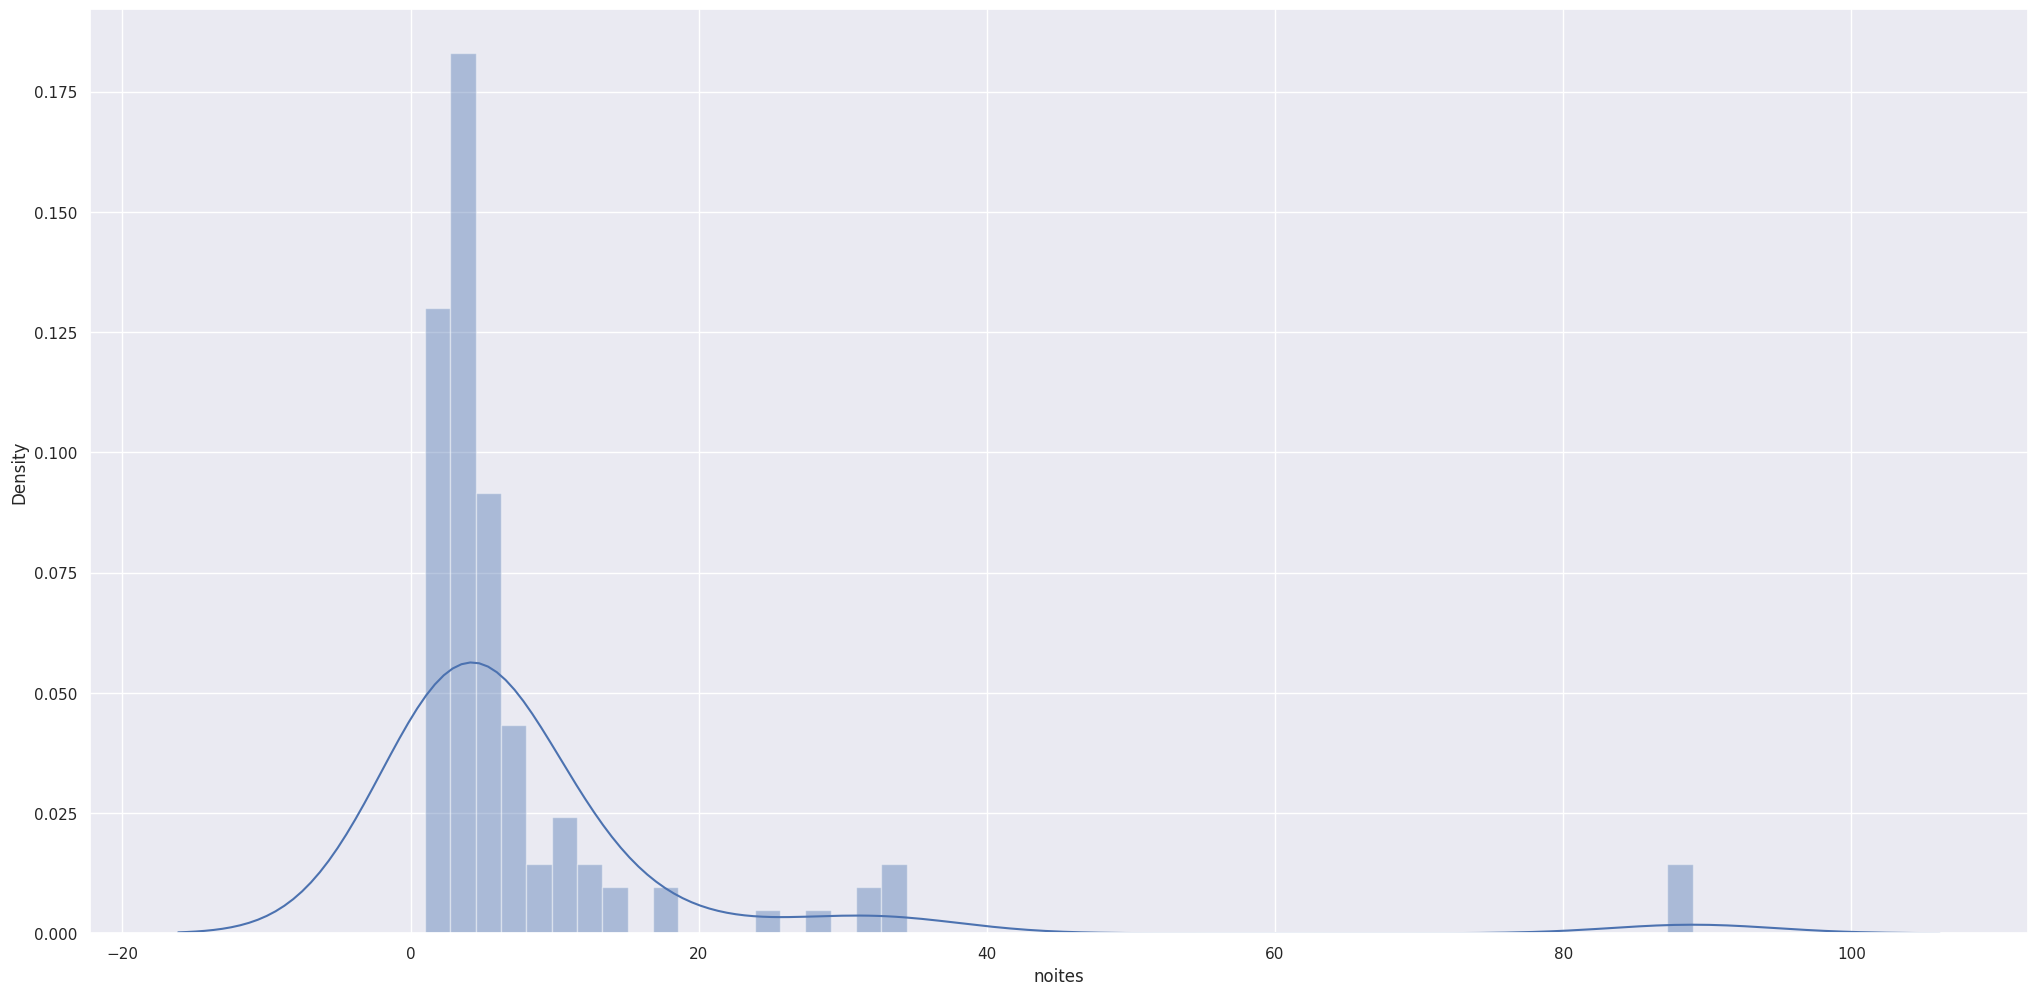

In [35]:
#Distribuição das diarias
sns.distplot(df1["noites"]);


### **1.7.2 Categorical Attributes**

In [36]:
#não aplica

# **2.0 Feature Engineering**

In [37]:
df2 = df1.copy()

## **2.1 Mind Map Hypotesis**

## **2.2 Hypotesis**

### **2.2.1 Hipóteses Padrões de Reserva**

1. Existe um aumento no número de reservas em meses específicos do ano (alta temporada)?
2. A maioria das reservas é feita com quantos dias de antecedência?
3. Datas como feriados nacionais ou eventos internacionais costumam estar reservadas?
4. Qual é a porcentagem de reservas com menos de 3 noites em relação às que excedem 7 noites?
5. Reservas podem ser agrupadas em segmentos de valor (baixo, médio, alto), e esses grupos apresentam comportamentos distintos?
6. Tem meses com tendência a ter mais reservas?

### **2.2.2 Hipóteses Valor e Preço**

1. Estadas mais longas têm um valor médio por noite mais baixo?
2. Existe uma variação clara de preços dependendo do mês?
3. Reservas realizadas durante feriados ou eventos locais apresentam um aumento significativo no valor médio por noite?
4. Qual a porcentagem do valor médio por noite para hóspedagens em grupos em relação a hospedagens individuais?
5. Preços ajustados com base na demanda de hóspedes, resultam em maior receita mensal?
6. Qual o valor padrão das reservas? E quais os valores dispcrepantes?

### **2.2.3 Hipóteses Perfil do Hóspede**

1. Se disponível, hóspedes de determinadas regiões tendem a fazer reservas de maior valor?
2. A distribuição percentual de hóspedes por região segue padrões consistentes ao longo do tempo, com certas localidades dominando a maior parte das reservas?

### **2.2.4 Hipóteses Desempenho Financeiro**

1. Existem variações significativas de ganho mensal, e como elas se relacionam com o número de reservas?
2. Qual é o impacto das taxas de serviço e impostos na receita líquida por reserva?
3. O custo médio da taxa de limpeza impacta mais negativamente reservas de curta duração?
4. Quais meses oferecem maior margem de lucro considerando receitas e custos?
5. Reservas feitas com preços ajustados dinamicamente aumentam a margem de lucro?
6. A receita total cresce consistentemente mês a mês ou ano a ano?
7. Qual é o ROI de melhorias realizadas no imóvel ou de investimentos em marketing?

## **2.3 Hypotheses Final List**

1. Existe um aumento no número de reservas em meses específicos do ano (alta temporada)?
1. A maioria das reservas é feita com quantos dias de antecedência?
1. Datas como feriados nacionais costumam estar reservadas?
1. Qual é a porcentagem de reservas com menos de 3 noites em relação às que excedem 7 noites?
1. Reservas podem ser agrupadas em segmentos de valor (baixo, médio, alto), e esses grupos apresentam comportamentos distintos?
1. Tem meses com tendência a ter mais reservas?
1. Estadas mais longas têm um valor médio por noite mais baixo?
1. Existe uma variação clara de preços dependendo do mês?
1. Reservas realizadas durante feriados apresentam um aumento significativo no valor médio por noite?
1. Qual a porcentagem do valor médio por noite para hóspedagens em grupos em relação a hospedagens individuais?
1. Preços ajustados com base na demanda de hóspedes, resultam em maior receita mensal?
1. Qual o valor padrão das reservas? E quais os valores dispcrepantes?
1. Se disponível, hóspedes de determinadas regiões tendem a fazer reservas de maior valor?
1. A distribuição percentual de hóspedes por região segue padrões consistentes ao longo do tempo, com certas localidades dominando a maior parte das reservas?
1. Existem variações significativas de ganho mensal, e como elas se relacionam com o número de reservas?
1. Qual é o impacto das taxas de serviço e impostos na receita líquida por reserva?
1. O custo médio da taxa de limpeza impacta mais negativamente reservas de curta duração?
1. Quais meses oferecem maior margem de lucro considerando receitas e custos?
1. Reservas feitas com preços ajustados dinamicamente aumentam a margem de lucro?
1. A receita total cresce consistentemente mês a mês ou ano a ano?
1. Qual é o ROI de melhorias realizadas no imóvel?

## **2.4 Feature Engineering**

In [38]:
df2.head()

,data,disponível por data,tipo,código de confirmação,data da reserva,data de início,data de término,noites,hóspede,anúncio,detalhes,código de referência,moeda,valor,pago,taxa de serviço,taxa de pagamento rápido,taxa de limpeza,ganhos brutos,impostos de ocupação,ganhos do ano
0,2022-12-12,2022-12-14,Payout,NaN,NaT,NaT,NaT,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3nd...,BRL,NaN,3286.69,NaN,NaN,NaN,NaN,NaN,NaT
1,2022-12-12,NaT,Reserva,HMAH343HFP,2022-10-03,2022-10-10,2023-01-07,89.0,Katarine Costa,The Águas Claras experience,NaN,NaN,BRL,3286.69,NaN,101.74,NaN,31.46,3388.43,0.0,1970-01-01 00:00:00.000002022
2,2022-11-11,2022-11-16,Payout,NaN,NaT,NaT,NaT,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3ne...,BRL,NaN,3521.45,NaN,NaN,NaN,NaN,NaN,NaT
3,2022-11-11,NaT,Reserva,HMAH343HFP,2022-10-03,2022-10-10,2023-01-07,89.0,Katarine Costa,The Águas Claras experience,NaN,NaN,BRL,3521.45,NaN,109.01,NaN,33.71,3630.46,0.0,1970-01-01 00:00:00.000002022
4,2022-10-11,2022-10-14,Payout,NaN,NaT,NaT,NaT,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3ne...,BRL,NaN,3638.83,NaN,NaN,NaN,NaN,NaN,NaT


In [39]:
# Variáveis a ser derivadas da variavel original Date
# year
df2["ano"] = df2["data"].dt.year

#df2["ganhos do ano"] = df2["ganhos do ano"].dt.year


# month
df2["mes"] = df2["data"].dt.month

# day
df2["dia"] = df2["data"].dt.day

# week of year
df2["semana_do_ano"] = df2["data"].dt.isocalendar().week

# year week (%Y ano, %W semana)
df2["ano_semana"] = df2["data"].dt.strftime("%Y-%W")

# Coluna Qtd Hospedes (colocar manual, não vem no csv)
df2["quantidade_hospedes"] = None

In [40]:
df2.head()

,data,disponível por data,tipo,código de confirmação,data da reserva,data de início,data de término,noites,hóspede,anúncio,detalhes,código de referência,moeda,valor,pago,taxa de serviço,taxa de pagamento rápido,taxa de limpeza,ganhos brutos,impostos de ocupação,ganhos do ano,ano,mes,dia,semana_do_ano,ano_semana,quantidade_hospedes
0,2022-12-12,2022-12-14,Payout,NaN,NaT,NaT,NaT,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3nd...,BRL,NaN,3286.69,NaN,NaN,NaN,NaN,NaN,NaT,2022,12,12,50,2022-50,None
1,2022-12-12,NaT,Reserva,HMAH343HFP,2022-10-03,2022-10-10,2023-01-07,89.0,Katarine Costa,The Águas Claras experience,NaN,NaN,BRL,3286.69,NaN,101.74,NaN,31.46,3388.43,0.0,1970-01-01 00:00:00.000002022,2022,12,12,50,2022-50,None
2,2022-11-11,2022-11-16,Payout,NaN,NaT,NaT,NaT,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3ne...,BRL,NaN,3521.45,NaN,NaN,NaN,NaN,NaN,NaT,2022,11,11,45,2022-45,None
3,2022-11-11,NaT,Reserva,HMAH343HFP,2022-10-03,2022-10-10,2023-01-07,89.0,Katarine Costa,The Águas Claras experience,NaN,NaN,BRL,3521.45,NaN,109.01,NaN,33.71,3630.46,0.0,1970-01-01 00:00:00.000002022,2022,11,11,45,2022-45,None
4,2022-10-11,2022-10-14,Payout,NaN,NaT,NaT,NaT,NaN,NaN,NaN,"Transferir para Raquel Rocha, •••••3540 (BRL)",Identificação de pagamento da Payoneer: 0MS3ne...,BRL,NaN,3638.83,NaN,NaN,NaN,NaN,NaN,NaT,2022,10,11,41,2022-41,None


In [41]:
# Reorganiza as colunas para que 'ano' e 'mes' fiquem ao lado de 'data'
colunas = ['data', 'ano', 'mes', 'dia', 'semana_do_ano', 'ano_semana'] + [col for col in df2.columns if col not in ['data', 'ano', 'mes', 'dia', 'semana_do_ano', 'ano_semana']]
df2 = df2[colunas]

In [42]:
#nova coluna Valor liquido

# Calcular o valor líquido apenas para linhas onde o tipo é "Reserva"
df2.loc[df2['tipo'] == 'Reserva', 'valor_liquido'] = df2['valor'] - df2['taxa de limpeza']

#Calcular o valor da diária apenas para linhas onde o tipo é "Reserva"
df2.loc[df2['tipo'] == 'Reserva', 'valor_diaria'] = df2['valor_liquido'] / df2['noites']

In [43]:
df2['valor_diaria'] = df2['valor_diaria'].round(2)


In [44]:
#df2[df2['ano'] == 2024].head(10)

In [45]:
print("Numero de linhas:{}".format(df2.shape[0]))
print("Numero de colunas:{}".format(df2.shape[1]))

Numero de linhas:240
Numero de colunas:29


# **3.0 DATA FILTERING**

In [46]:
df3 = df2.copy()

In [47]:
#teve valor na coluna pago referente a coluna tipo ao atributo Payout diferente valor da coluna valor na coluna tipo atributo reserva?

df_payout = df3[df3['tipo'] == 'Payout']
df_reserva = df3[df3['tipo'] == 'Reserva']

df_comparado = pd.merge(df_reserva[['código de confirmação', 'valor']],
                        df_payout[['código de confirmação', 'pago']],
                        on='código de confirmação',
                        how='inner')

df_comparado['diferente'] = df_comparado['valor'] != df_comparado['pago']

linhas_diferentes = df_comparado[df_comparado['diferente']]

print(linhas_diferentes)

Empty DataFrame
Columns: [código de confirmação, valor, pago, diferente]
Index: []


## **3.1 Row filtering**

In [48]:
df3 = df3[df3["tipo"] == "Reserva"]

## **3.2 Column selection**

In [49]:
#Observacão: se um dia tiver 2airbnb tem que deixar a coluna de anuncio
df3 = df3.drop(columns=['anúncio', 'taxa de serviço', 'código de referência', 'detalhes', 'ganhos do ano','tipo', 'pago', 'taxa de pagamento rápido', 'impostos de ocupação', 'disponível por data' ])

In [50]:
# Corrigir a conversão para o formato correto
df3["data de início"] = pd.to_datetime(df3["data de início"], format='%y/%m/%d')
df3["data de término"] = pd.to_datetime(df3["data de término"], format='%y/%m/%d')
df3["data da reserva"] = pd.to_datetime(df3["data da reserva"], format='%y/%m/%d')
df3["data"] = pd.to_datetime(df3["data"], format='%y/%m/%d')


# Agora, para garantir que as datas fiquem no formato brasileiro (DD/MM/YYYY), use o .dt.strftime
df3["data de início"] = df3["data de início"].dt.strftime('%d/%m/%Y')
df3["data de término"] = df3["data de término"].dt.strftime('%d/%m/%Y')
df3["data da reserva"] = df3["data da reserva"].dt.strftime('%d/%m/%Y')
df3["data"] = df3["data"].dt.strftime('%d/%m/%Y')


In [51]:
df3.head()

,data,ano,mes,dia,semana_do_ano,ano_semana,código de confirmação,data da reserva,data de início,data de término,noites,hóspede,moeda,valor,taxa de limpeza,ganhos brutos,quantidade_hospedes,valor_liquido,valor_diaria
1,12/12/2022,2022,12,12,50,2022-50,HMAH343HFP,03/10/2022,10/10/2022,07/01/2023,89.0,Katarine Costa,BRL,3286.69,31.46,3388.43,None,3255.23,36.58
3,11/11/2022,2022,11,11,45,2022-45,HMAH343HFP,03/10/2022,10/10/2022,07/01/2023,89.0,Katarine Costa,BRL,3521.45,33.71,3630.46,None,3487.74,39.19
5,11/10/2022,2022,10,11,41,2022-41,HMAH343HFP,03/10/2022,10/10/2022,07/01/2023,89.0,Katarine Costa,BRL,3638.83,34.83,3751.47,None,3604.00,40.49
7,01/10/2022,2022,10,1,39,2022-39,HMJ8PY5CY8,27/09/2022,30/09/2022,09/10/2022,9.0,Andressa Silveira,BRL,1124.16,100.00,1158.96,None,1024.16,113.80
9,23/09/2022,2022,9,23,38,2022-38,HMMYZJMFKC,07/09/2022,22/09/2022,24/09/2022,2.0,Jefferson De Andrade,BRL,261.66,70.00,269.76,None,191.66,95.83


In [52]:
# Garantir que TODAS as colunas de data estejam no formato datetime antes de manipular
df3["data"] = pd.to_datetime(df3["data"], format="%d/%m/%Y", errors="coerce")
df3["data de início"] = pd.to_datetime(df3["data de início"], format="%d/%m/%Y", errors="coerce")
df3["data de término"] = pd.to_datetime(df3["data de término"], format="%d/%m/%Y", errors="coerce")

# Ajustando as datas de início e término com base na coluna "data"
for i, row in df3.iterrows():
    referencia = row["data"]  # Data usada como referência para o mês correto
    start_date = row["data de início"]
    end_date = row["data de término"]

    # Garantir que não temos valores nulos antes de manipular
    if pd.notna(referencia) and pd.notna(start_date) and pd.notna(end_date):
        # Se a data de início não pertence ao mês de referência, ajustamos para o primeiro dia do mês correto
        if start_date.month != referencia.month:
            start_date = referencia.replace(day=1)

        # Se a data de término não pertence ao mês de referência, ajustamos para o último dia do mês correto
        if end_date.month != referencia.month:
            # Se o mês for dezembro, garantir que a data de término seja 07/01/2023
            if referencia.month == 12:
                end_date = pd.to_datetime("07/01/2023", format="%d/%m/%Y")
            else:
                end_date = referencia.replace(day=1) + pd.DateOffset(months=1) - pd.Timedelta(days=1)

        # Atualizando as colunas no DataFrame
        df3.at[i, "data de início"] = start_date
        df3.at[i, "data de término"] = end_date

# Converter novamente para o formato brasileiro DD/MM/YYYY
df3["data de início"] = df3["data de início"].dt.strftime("%d/%m/%Y")
df3["data de término"] = df3["data de término"].dt.strftime("%d/%m/%Y")


In [53]:
# Converter as colunas de data para datetime
df3["data de início"] = pd.to_datetime(df3["data de início"], format="%d/%m/%Y", errors="coerce")
df3["data de término"] = pd.to_datetime(df3["data de término"], format="%d/%m/%Y", errors="coerce")

# Cria máscara
mask_katarine = df3["hóspede"] == "Katarine Costa"

# Calcula o número de noites
df3.loc[mask_katarine, "noites"] = (df3.loc[mask_katarine, "data de término"] - df3.loc[mask_katarine, "data de início"]).dt.days

# Identifica as transições de mês
df3.loc[mask_katarine, "mes_inicio"] = df3.loc[mask_katarine, "data de início"].dt.month
df3.loc[mask_katarine, "mes_fim"] = df3.loc[mask_katarine, "data de término"].dt.month

# Somar +1 noite SOMENTE quando houver mudança de mês
df3.loc[mask_katarine & (df3["mes_inicio"] != df3["mes_fim"]), "noites"] += 1

# Adicionar 1 noite na transição de outubro para novembro
df3.loc[mask_katarine & (df3["mes_inicio"] == 10) & (df3["mes_fim"] == 11), "noites"] += 1

# Remover colunas auxiliares
df3.drop(columns=["mes_inicio", "mes_fim"], inplace=True)

# Converter de volta para string no formato DD/MM/YYYY
df3["data de início"] = df3["data de início"].dt.strftime("%d/%m/%Y")
df3["data de término"] = df3["data de término"].dt.strftime("%d/%m/%Y")

print(df3[df3["hóspede"] == "Katarine Costa"][["data de início", "data de término", "noites"]])


  data de início data de término  noites
1     01/12/2022      07/01/2023    38.0
3     01/11/2022      30/11/2022    29.0
5     10/10/2022      31/10/2022    21.0


In [54]:
df3[df3["noites"] < 0]

,data,ano,mes,dia,semana_do_ano,ano_semana,código de confirmação,data da reserva,data de início,data de término,noites,hóspede,moeda,valor,taxa de limpeza,ganhos brutos,quantidade_hospedes,valor_liquido,valor_diaria


In [55]:
df3.head()

,data,ano,mes,dia,semana_do_ano,ano_semana,código de confirmação,data da reserva,data de início,data de término,noites,hóspede,moeda,valor,taxa de limpeza,ganhos brutos,quantidade_hospedes,valor_liquido,valor_diaria
1,2022-12-12,2022,12,12,50,2022-50,HMAH343HFP,03/10/2022,01/12/2022,07/01/2023,38.0,Katarine Costa,BRL,3286.69,31.46,3388.43,None,3255.23,36.58
3,2022-11-11,2022,11,11,45,2022-45,HMAH343HFP,03/10/2022,01/11/2022,30/11/2022,29.0,Katarine Costa,BRL,3521.45,33.71,3630.46,None,3487.74,39.19
5,2022-10-11,2022,10,11,41,2022-41,HMAH343HFP,03/10/2022,10/10/2022,31/10/2022,21.0,Katarine Costa,BRL,3638.83,34.83,3751.47,None,3604.00,40.49
7,2022-10-01,2022,10,1,39,2022-39,HMJ8PY5CY8,27/09/2022,01/10/2022,09/10/2022,9.0,Andressa Silveira,BRL,1124.16,100.00,1158.96,None,1024.16,113.80
9,2022-09-23,2022,9,23,38,2022-38,HMMYZJMFKC,07/09/2022,22/09/2022,24/09/2022,2.0,Jefferson De Andrade,BRL,261.66,70.00,269.76,None,191.66,95.83


### **Compreendendo Algumas Possibilidades**

In [56]:
valores_unicos = df3['valor'].dropna().unique()
print(valores_unicos)

[3286.69 3521.45 3638.83 1124.16  261.66  792.    484.55  531.22 1541.47
  513.63 1705.62 1525.37  693.88  868.32  870.26 2679.57  703.57  958.44
  711.32 2336.51  752.02  664.81 5331.02 2559.38 2753.22  947.78 1451.72
  726.83  649.3   629.92  872.19  508.78  590.18  494.24 1819.98  558.2
 1211.38  687.09 1521.49  833.43  920.65  564.99  396.36  648.33  971.04
  537.85 1569.95  523.32  571.77 2132.03 1043.73  616.35 1303.44 1595.15
  967.17 1897.51  883.82  930.34  997.21  941.97  288.09 1393.57 1502.11
  719.97  424.47  854.75  540.76 1584.33  647.36 1805.18  632.35 4742.61
 5378.53 1112.66 2940.26 1240.45  608.6  1541.84 1444.06 1402.29 1360.62
  684.19  529.13  661.9   385.7  1383.59 1103.23  511.69  505.87  705.5
 3477.12 1146.46  760.13  754.33 1123.19  774.62 1110.73 1222.04 3589.11
  902.24  713.26 1269.53  940.03  772.38 3356.98  287.82  859.6  1332.52
  621.2  1248.21]


In [57]:
df3['valor'].mean()

np.float64(1253.610088495575)

In [58]:
df3['valor'].median()

930.34

In [59]:
df3['valor'].max()

5378.53

In [60]:
df3.loc[df3['valor'] > 0, 'valor'].min()

261.66

In [61]:
# Filtrar apenas o Marcelo
# Agrupar por tipo e soma os valores pagos

marcelo_df = df1[df1['hóspede'] == 'Marcelo Mainardi']
pagamento_por_tipo = marcelo_df.groupby('tipo')['valor'].sum()

print(pagamento_por_tipo)

tipo
Pagamento da Resolução     534.75
Reserva                   1502.11
Name: valor, dtype: float64


In [62]:
#valores não negativos
# Acha o índice
# loc na linha do DataFrame

df_valores_positivos = df3[df3['valor'] > 0]
indice_menor_valor = df_valores_positivos['valor'].idxmin()
linha_menor_valor = df3.loc[indice_menor_valor]

print(linha_menor_valor)

data                      2022-09-23 00:00:00
ano                                      2022
mes                                         9
dia                                        23
semana_do_ano                              38
ano_semana                            2022-38
código de confirmação              HMMYZJMFKC
data da reserva                    07/09/2022
data de início                     22/09/2022
data de término                    24/09/2022
noites                                    2.0
hóspede                  Jefferson De Andrade
moeda                                     BRL
valor                                  261.66
taxa de limpeza                          70.0
ganhos brutos                          269.76
quantidade_hospedes                      None
valor_liquido                          191.66
valor_diaria                            95.83
Name: 9, dtype: object


In [63]:
#verificação, antes contava o minimo de 8 reais, mas era do tipo de pagamento de resolução, foi resolvido
#por isso essa linha de código
marcelo_df = df3[df3['hóspede'] == 'Marcelo Mainardi']

print(marcelo_df)

# aqui rever se retirou os tipos de reserva que não são reserva, pois resolução de pagamento não deveria entrar aqui

          data   ano  mes  dia  semana_do_ano ano_semana código de confirmação data da reserva data de início data de término  noites           hóspede moeda    valor  taxa de limpeza  ganhos brutos quantidade_hospedes  valor_liquido  valor_diaria
139 2024-10-15  2024   10   15             42    2024-42            HMK3AXB4HK      14/10/2024     14/10/2024      21/10/2024     7.0  Marcelo Mainardi   BRL  1502.11              0.0        1548.61                None        1502.11        214.59


In [64]:
#agora etá correto o valor minimo de hospedagem
df3[df3['valor'] == df3.loc[df3['valor'] > 0, 'valor'].min()]


,data,ano,mes,dia,semana_do_ano,ano_semana,código de confirmação,data da reserva,data de início,data de término,noites,hóspede,moeda,valor,taxa de limpeza,ganhos brutos,quantidade_hospedes,valor_liquido,valor_diaria
9,2022-09-23,2022,9,23,38,2022-38,HMMYZJMFKC,07/09/2022,22/09/2022,24/09/2022,2.0,Jefferson De Andrade,BRL,261.66,70.0,269.76,None,191.66,95.83


In [65]:
# Contar frequências de cada número
ranking = df3['noites'].value_counts().sort_index()

# Exibir o ranking como inteiros
print("Frequência de Ocorrências por Número de Noites:")
for numero, frequencia in ranking.items():
    print(f"{int(numero)} noites: {int(frequencia)} ocorrência(s)")

Frequência de Ocorrências por Número de Noites:
1 noites: 1 ocorrência(s)
2 noites: 26 ocorrência(s)
3 noites: 21 ocorrência(s)
4 noites: 17 ocorrência(s)
5 noites: 11 ocorrência(s)
6 noites: 8 ocorrência(s)
7 noites: 2 ocorrência(s)
8 noites: 4 ocorrência(s)
9 noites: 3 ocorrência(s)
10 noites: 2 ocorrência(s)
11 noites: 3 ocorrência(s)
12 noites: 2 ocorrência(s)
13 noites: 1 ocorrência(s)
14 noites: 1 ocorrência(s)
15 noites: 1 ocorrência(s)
17 noites: 1 ocorrência(s)
18 noites: 1 ocorrência(s)
21 noites: 1 ocorrência(s)
24 noites: 1 ocorrência(s)
29 noites: 2 ocorrência(s)
31 noites: 1 ocorrência(s)
34 noites: 2 ocorrência(s)
38 noites: 1 ocorrência(s)


In [66]:
# Convertendo as datas
df3['data de início'] = pd.to_datetime(df3['data de início'], errors='coerce')
df3['data de término'] = pd.to_datetime(df3['data de término'], errors='coerce')

# Filtrando apenas as linhas com datas válidas
df_reservas = df3[df3['data de início'].notna() & df3['data de término'].notna()]

# Gerando linhas diárias por reserva
linhas = []
for _, row in df_reservas.iterrows():
    intervalo = pd.date_range(start=row['data de início'], end=row['data de término'])
    for data in intervalo:
        linhas.append({
            'data_da_diaria': data,
            'ano': data.year,
            'mes': data.month,
            'dia': data.day,
            'dia_da_semana': data.day_name(),
            'hóspede': row['hóspede'],
            'código de confirmação': row['código de confirmação'],
            'valor_total': row['valor'],
            'noites': row['noites'],
            'data_inicio': row['data de início'],
            'data_termino': row['data de término']
        })

# Criando o novo DataFrame
df33 = pd.DataFrame(linhas)


In [67]:
df3['data de início'] = pd.to_datetime(df3['data de início'], errors='coerce')
df3['data de término'] = pd.to_datetime(df3['data de término'], errors='coerce')

#df_reservas = df3[(df3['tipo'] == 'Reserva') & df3['data de início'].notna() & df3['data de término'].notna()]

linhas = []
for _, row in df_reservas.iterrows():
    intervalo = pd.date_range(start=row['data de início'], end=row['data de término'])
    for data in intervalo:
        linhas.append({
            'data_da_diaria': data,
            'ano': data.year,
            'mes': data.month,
            'dia': data.day,
            'dia_da_semana': data.day_name(),
            'hóspede': row['hóspede'],
            'código de confirmação': row['código de confirmação'],
            'valor': row['valor'],
            'noites': row['noites'],
            'data de início': row['data de início'],
            'data de término': row['data de término']
        })

# 5. Criação do novo DataFrame
df33 = pd.DataFrame(linhas)

In [68]:
df33.columns


Index(['data_da_diaria', 'ano', 'mes', 'dia', 'dia_da_semana', 'hóspede',
       'código de confirmação', 'valor', 'noites', 'data de início',
       'data de término'],
      dtype='object')

In [69]:
# Filtra as linhas onde o ano é 2023
df_2023 = df3[df3['ano'] == 2023]

# Soma o valor da coluna 'pago' para cada mês em 2023
receita_mensal_2023 = df_2023.groupby(['ano', 'mes'])['valor'].sum().reset_index()

# Ordena o DataFrame por mês
receita_mensal_2023 = receita_mensal_2023.sort_values(by='mes').reset_index(drop=True)

# Calcula a média das receitas mensais em 2023
media_receita_mensal_2023 = receita_mensal_2023['valor'].mean()

print("Receita mensal somada por mês em 2023:")
print(receita_mensal_2023)
print("\nMédia da receita mensal em 2023:", media_receita_mensal_2023)


Receita mensal somada por mês em 2023:
     ano  mes    valor
0   2023    1  2665.04
1   2023    2   537.85
2   2023    3  2580.72
3   2023    4  4520.86
4   2023    5  3589.56
5   2023    6  3095.31
6   2023    7  2323.91
7   2023    8  7712.10
8   2023    9  5331.02
9   2023   10  3753.34
10  2023   11  5052.90
11  2023   12  6177.08

Média da receita mensal em 2023: 3944.9741666666673


In [70]:
# Filtra as linhas onde o ano é 2024
df_2024 = df3[df3['ano'] == 2024]

# Soma o valor da coluna 'pago' para cada mês em 2024
receita_mensal_2024 = df_2024.groupby(['ano', 'mes'])['valor'].sum().reset_index()

# Ordena o DataFrame por mês
receita_mensal_2024 = receita_mensal_2024.sort_values(by='mes').reset_index(drop=True)

# média das receitas mensais em 2024
media_receita_mensal_2024 = receita_mensal_2024['valor'].mean()

print("Receita mensal somada por mês em 2024:")
print(receita_mensal_2024)
print("\nMédia da receita mensal em 2024:", media_receita_mensal_2024)

Receita mensal somada por mês em 2024:
     ano  mes    valor
0   2024    1  1211.37
1   2024    2  2998.51
2   2024    3  4551.88
3   2024    4  6237.24
4   2024    5  9431.45
5   2024    6  4742.61
6   2024    7   632.35
7   2024    8  1805.18
8   2024    9  4051.67
9   2024   10  3903.74
10  2024   11  6618.02
11  2024   12  6690.70

Média da receita mensal em 2024: 4406.226666666666


In [71]:
# Filtra as linhas onde o ano é 2025
df_2025 = df3[df3['ano'] == 2025]

# Soma o valor da coluna 'pago' para cada mês em 2025
receita_mensal_2025 = df_2025.groupby(['ano', 'mes'])['valor'].sum().reset_index()

# Ordena o DataFrame por mês
receita_mensal_2025 = receita_mensal_2025.sort_values(by='mes').reset_index(drop=True)

# média das receitas mensais em 2025
media_receita_mensal_2025 = receita_mensal_2025['valor'].mean()

print("Receita mensal somada por mês em 2025:")
print(receita_mensal_2025)
print("\nMédia da receita mensal em 2025:", media_receita_mensal_2025)


Receita mensal somada por mês em 2025:
    ano  mes    valor
0  2025    1  4061.53
1  2025    2  3644.80
2  2025    3  4597.44
3  2025    4  3589.11
4  2025    5  6891.50
5  2025    6  3477.12

Média da receita mensal em 2025: 4376.916666666667


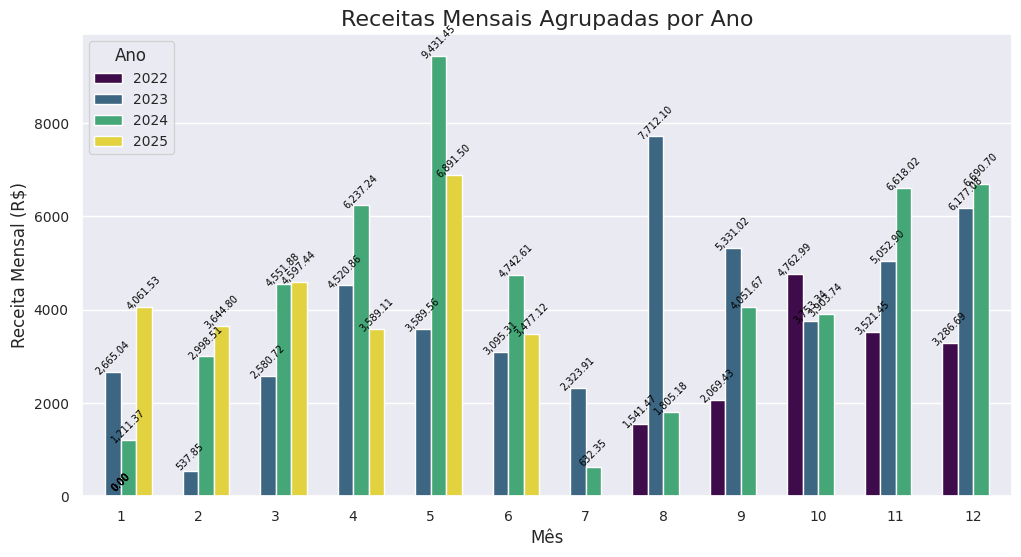

In [72]:
receita_ano_mes = df3.groupby(['ano', 'mes'])['valor'].sum().reset_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=receita_ano_mes, x='mes', y='valor', hue='ano', palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=7, color='black',
                xytext=(0, 10), textcoords='offset points',
               rotation=45)

plt.title('Receitas Mensais Agrupadas por Ano', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Receita Mensal (R$)', fontsize=12)
plt.legend(title='Ano', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [73]:
#df3.to_excel("airbnb_dash.xlsx", index=False)

In [74]:
df3.columns

Index(['data', 'ano', 'mes', 'dia', 'semana_do_ano', 'ano_semana',
       'código de confirmação', 'data da reserva', 'data de início',
       'data de término', 'noites', 'hóspede', 'moeda', 'valor',
       'taxa de limpeza', 'ganhos brutos', 'quantidade_hospedes',
       'valor_liquido', 'valor_diaria'],
      dtype='object')

In [75]:
df3.head()

,data,ano,mes,dia,semana_do_ano,ano_semana,código de confirmação,data da reserva,data de início,data de término,noites,hóspede,moeda,valor,taxa de limpeza,ganhos brutos,quantidade_hospedes,valor_liquido,valor_diaria
1,2022-12-12,2022,12,12,50,2022-50,HMAH343HFP,03/10/2022,2022-01-12,2023-07-01,38.0,Katarine Costa,BRL,3286.69,31.46,3388.43,None,3255.23,36.58
3,2022-11-11,2022,11,11,45,2022-45,HMAH343HFP,03/10/2022,2022-01-11,NaT,29.0,Katarine Costa,BRL,3521.45,33.71,3630.46,None,3487.74,39.19
5,2022-10-11,2022,10,11,41,2022-41,HMAH343HFP,03/10/2022,2022-10-10,NaT,21.0,Katarine Costa,BRL,3638.83,34.83,3751.47,None,3604.00,40.49
7,2022-10-01,2022,10,1,39,2022-39,HMJ8PY5CY8,27/09/2022,2022-01-10,2022-09-10,9.0,Andressa Silveira,BRL,1124.16,100.00,1158.96,None,1024.16,113.80
9,2022-09-23,2022,9,23,38,2022-38,HMMYZJMFKC,07/09/2022,NaT,NaT,2.0,Jefferson De Andrade,BRL,261.66,70.00,269.76,None,191.66,95.83


In [76]:
df3['data de início'] = pd.to_datetime(df3['data de início'], errors='coerce')
df3['data de término'] = pd.to_datetime(df3['data de término'], errors='coerce')

#df_reservas = df3[(df3['tipo'] == 'Reserva') & df3['data de início'].notna() & df3['data de término'].notna()]

linhas = []
for _, row in df_reservas.iterrows():
    intervalo = pd.date_range(start=row['data de início'], end=row['data de término'])
    for data in intervalo:
        linhas.append({
            'data': data,
            'ano': data.year,
            'mes': data.month,
            'dia': data.day,
            'dia da semana': data.day_name(),
            'hóspede': row['hóspede'],
            'código de confirmação': row['código de confirmação'],
            'valor': row['valor'],
            'noites': row['noites'],
            'data de início': row['data de início'],
            'data de término': row['data de término']
        })

# 5. Criação do novo DataFrame
df33 = pd.DataFrame(linhas)

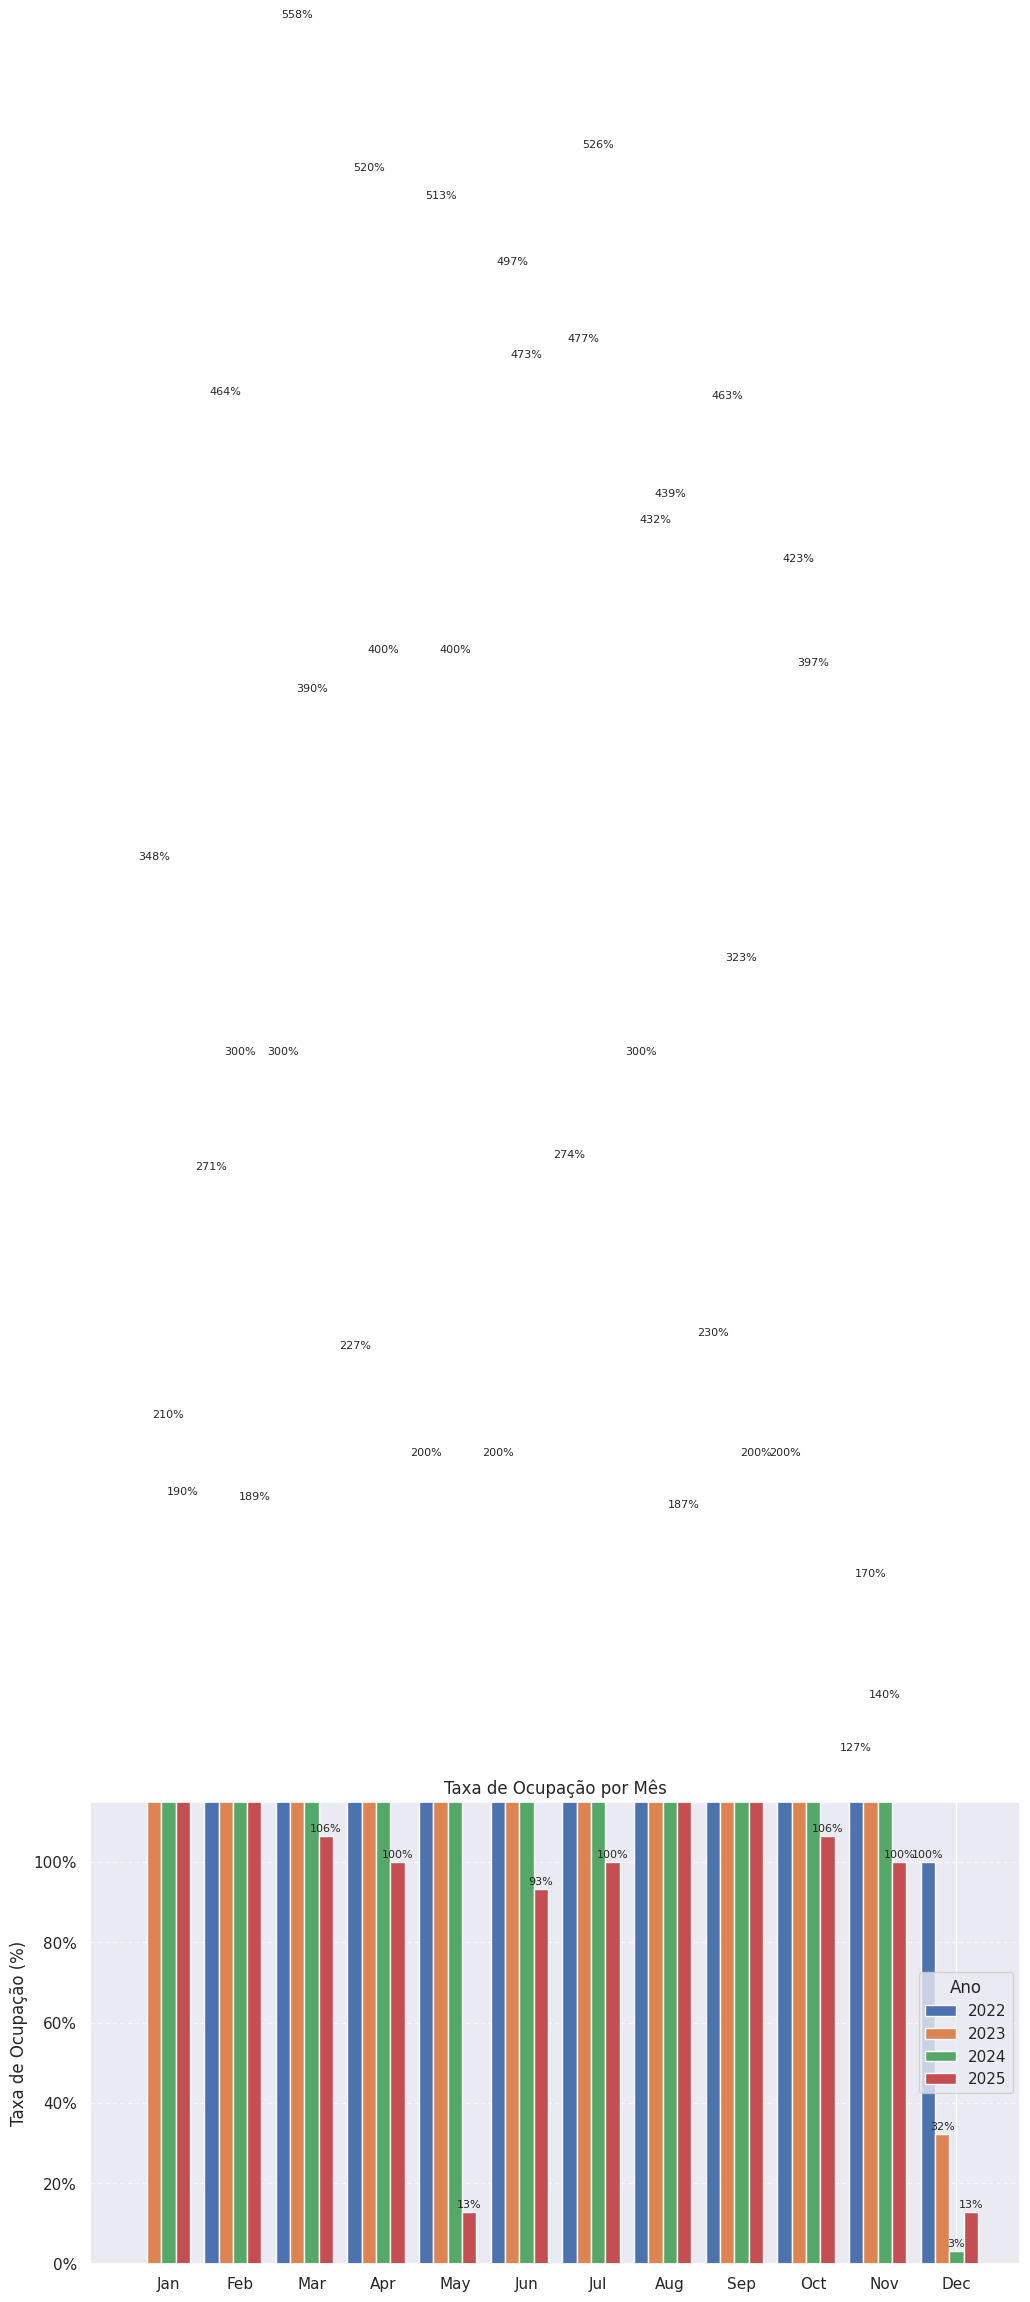

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np

# Converter datas
df3["data de início"] = pd.to_datetime(df3["data de início"], format="%d/%m/%Y", errors="coerce")
df3["data de término"] = pd.to_datetime(df3["data de término"], format="%d/%m/%Y", errors="coerce")
df3 = df3.dropna(subset=["data de início", "data de término"])
df3 = df3[df3["data de término"] > df3["data de início"]]  # Ignorar estadias inválidas

# Expandir dias ocupados por mês
todas_datas = []
for _, row in df3.iterrows():
    periodo = pd.date_range(row["data de início"], row["data de término"] - pd.Timedelta(days=1))
    for dia in periodo:
        todas_datas.append({"ano": dia.year, "mes": dia.month})

# Contar dias ocupados por ano e mês
df_ocupados = pd.DataFrame(todas_datas).groupby(["ano", "mes"]).size().reset_index(name="dias_ocupados")

# Total de dias por mês no intervalo
todos_meses = pd.date_range(df3["data de início"].min(), df3["data de término"].max(), freq="MS")
df_dias_mes = pd.DataFrame([
    {"ano": d.year, "mes": d.month, "dias_totais": calendar.monthrange(d.year, d.month)[1]}
    for d in todos_meses
])

# Calcular taxa de ocupação
df_taxa = df_dias_mes.merge(df_ocupados, on=["ano", "mes"], how="left").fillna({"dias_ocupados": 0})
df_taxa["taxa_ocupacao"] = df_taxa["dias_ocupados"] / df_taxa["dias_totais"]

# Pivotar para gráfico
pivot = df_taxa.pivot(index="mes", columns="ano", values="taxa_ocupacao").fillna(0)

# Plotar gráfico
fig, ax = plt.subplots(figsize=(12, 6))
largura = 0.2
meses = np.arange(1, 13)
for i, ano in enumerate(sorted(pivot.columns)):
    valores = pivot[ano].reindex(meses, fill_value=0)
    posicoes = meses + i * largura - (largura * len(pivot.columns) / 2)
    barras = ax.bar(posicoes, valores, width=largura, label=str(ano))
    for barra in barras:
        if barra.get_height() > 0:
            ax.text(barra.get_x() + barra.get_width() / 2, barra.get_height() + 0.01,
                    f"{barra.get_height():.0%}", ha="center", fontsize=8)

# Configurar gráfico
ax.set_xticks(meses)
ax.set_xticklabels([calendar.month_abbr[m] for m in meses])
ax.set_ylabel("Taxa de Ocupação (%)")
ax.set_title("Taxa de Ocupação por Mês")
ax.legend(title="Ano")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
ax.set_ylim(0, 1.15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("taxa_ocupacao.png")

# **4.0 EDA**

## **4.1 Analise Univariada**

### **4.1.2 Numerical variable**

### **4.1.2 Numerical variable**

## **4.2 Analise Bivariada**

H1-

## **4.3 Analise Multivariada**

### **4.3.1 Numerical Attributes**

### **4.3.2 Categorical Attributes**